# Multi Batch Training Using GPU
## Introduction
As pointed out in `Introduction` of the notebook **(3.1) Model for Under_20.ipynb**, our group first attempted to train the bigger sample with 10,000 sentences by using GPU. However, due to a memory allocation issue of our device's GPU, we decided to split up the 10,000 sentences in different "batches" that are sequentially used to train the model. The steps can be summarized as:

(1) Divide the 10,000 sentences into four groups--2 groups with 3,000 sentences (groups A, B) and 2 groups with 2,000 sentences (groups C, D)

(2) Train a model using group A and save its structrue and weights as $W_{A}$

(3) Load $W_{A}$ and further train the model using group B and again save its structure and weights as $W_{B}$

(4) ...

## Note:
As the structure and processes shown here are mostly the same as the ones in **(3.1) Model for Under_20.ipynb** in the folder `Model Training/Under_20 Model Training`, many comments have been left out in this notebook for simplicity.

## I. Data preparation

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import numpy as np 
import pandas as pd
import time

import io
import json
import random
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
begin = time.time()

In [3]:
# Create an instance object of the tokenizer
tokenizer = Tokenizer()

data = pd.read_csv('../Data/sample_under_20.csv')
print("Number of sentences in the dataset:", data.shape[0])

corpus = data['0'].tolist()
random.shuffle(corpus)

# Divide the data into four parts
samples = [corpus[:3000], corpus[3000:6000], 
           corpus[6000:8000], corpus[8000:]]

# Tokenize the sentences
tokenizer.fit_on_texts(corpus)

total_words = len(tokenizer.word_index) + 1

print('There are %d unique words in total' %(total_words-1))

Number of sentences in the dataset: 10000
There are 16350 unique words in total


In [4]:
# Save tokenizer
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [5]:
def prepare_data(tokenizer, corpus, max_sequence_len):
    '''
    Returns predictors and target outputs for model training
    
    Parameters:
        tokenizer: the tokenizer that has been fit on the input text
        corpus (list): the subset of data that will be used for training
        max_sequence_len (int): the length of the longest sentence
            in the dataset
    '''
    input_sequences = []
    for line in corpus: 
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

    # Pad sequences 
    input_sequences = np.array(pad_sequences(input_sequences, 
                                             maxlen=max_sequence_len, padding='pre'))

    # Create predictors and label
    xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
    ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)
    
    return xs, ys

In [6]:
# Plot accuracy/loss graphs after model training finishes
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.title(string + " changes over epochs")
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

In [7]:
def text_generator(seed_text, next_words, tokenizer, 
                   model, max_sequence_len):
    '''
    Returns a block of text generated using a trained model.
    
    Parameters:
        seed_text (str): several words to start the block of text
        next_words (int): number of generated words desired
        tokenizer: tokenizer of the trained model
        model: trained model for text generation
        max_sequence_len: the biggest length of the sentences fed to the model
    '''
    for w in range(next_words):
        # Tokenize the previous words (i.e. the starting words when the 
        # text generation first begins)
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # Pad sequences
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, 
                                   padding='pre')
        # Generate model predictions based on the padded sequences
        predicted = model.predict_classes(token_list, verbose=0)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            # Look for the corresponding word of the predicted word index 
            # output by the model above
            if index == predicted:
                output_word = word
                break
        # Add the predicted word
        seed_text += " " + output_word
    return seed_text

In [8]:
del data
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
print('The longest sentence has %d words' %max_sequence_len)

The longest sentence has 40 words


## II. Model Training
### i. Initial Round using the first subset of text

In [9]:
sample = samples[0]
xs, ys = prepare_data(tokenizer, sample, max_sequence_len)

# Construct the model
model = Sequential()
model.add(Embedding(total_words, 150, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics=['accuracy'])

# Save the model
filepath = "model_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
                             save_best_only=True, mode='min')
desired_callbacks = [checkpoint]

history = model.fit(xs, ys, epochs=25, batch_size=64, verbose=1, 
                    callbacks=desired_callbacks)

print(model)
print(model.summary())

Epoch 1/25
739/739 [==============================] - 27s 31ms/step - loss: 6.9086 - accuracy: 0.0748

Epoch 00001: loss improved from inf to 6.90856, saving model to model_weights.hdf5
Epoch 2/25
739/739 [==============================] - 21s 28ms/step - loss: 6.0853 - accuracy: 0.1093

Epoch 00002: loss improved from 6.90856 to 6.08530, saving model to model_weights.hdf5
Epoch 3/25
739/739 [==============================] - 21s 28ms/step - loss: 5.2029 - accuracy: 0.1321

Epoch 00003: loss improved from 6.08530 to 5.20292, saving model to model_weights.hdf5
Epoch 4/25
739/739 [==============================] - 21s 29ms/step - loss: 4.5309 - accuracy: 0.1696

Epoch 00004: loss improved from 5.20292 to 4.53088, saving model to model_weights.hdf5
Epoch 5/25
739/739 [==============================] - 21s 28ms/step - loss: 3.9577 - accuracy: 0.2239

Epoch 00005: loss improved from 4.53088 to 3.95773, saving model to model_weights.hdf5
Epoch 6/25
739/739 [==============================] - 

In [10]:
del xs, ys

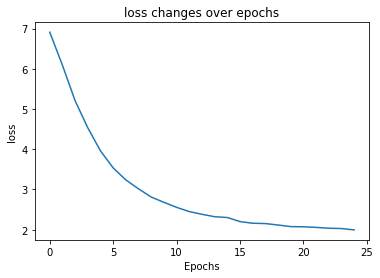

In [11]:
plot_graphs(history, 'loss')

The graph above shows that as the epoch number increases, the training losses have steadily decreased.

In [12]:
print(text_generator('it was a good day', 100, 
                     tokenizer, model, max_sequence_len))

it was a good day of the same exact thing whom it was winking at them at them at them at five till five hours to blogger and all that 59 did i really just can't help but i havnt slept by thugcov's sweeney and the doctor couldnt see what pissed off but hes hysterical of women and commitment in finding the calories with michael savage horrible plans and jes are bisaya 5 4 7 derby painfully her heart ramon hernandez anf ridden daijoubu kamo chicken willing shopping rivers shanda for a shot is extended beyond him morrell to know the balls online in the


The text generated above using the first 3,000 sentences have shown some sentence structure. However, it is  not making any sense yet.

### ii. Second Round using the second subset

In [13]:
# Load the model saved in the first round
model2 = tf.keras.models.load_model('model_weights.hdf5')

In [14]:
# Save the second model
filepath = "model_weights2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
                             save_best_only=True, mode='min')
desired_callbacks = [checkpoint]

sample = samples[1]
xs, ys = prepare_data(tokenizer, sample, max_sequence_len)
history2 = model2.fit(xs, ys, epochs=25, batch_size=64, verbose=1, 
                      callbacks=desired_callbacks)

print(model2)

Epoch 1/25
739/739 [==============================] - 23s 29ms/step - loss: 9.4710 - accuracy: 0.0677

Epoch 00001: loss improved from inf to 9.47100, saving model to model_weights2.hdf5
Epoch 2/25
739/739 [==============================] - 22s 30ms/step - loss: 6.6359 - accuracy: 0.09680s - loss: 6.6359 - accuracy: 0.09

Epoch 00002: loss improved from 9.47100 to 6.63594, saving model to model_weights2.hdf5
Epoch 3/25
739/739 [==============================] - 22s 29ms/step - loss: 5.4992 - accuracy: 0.1293

Epoch 00003: loss improved from 6.63594 to 5.49923, saving model to model_weights2.hdf5
Epoch 4/25
739/739 [==============================] - 21s 28ms/step - loss: 4.8638 - accuracy: 0.1647

Epoch 00004: loss improved from 5.49923 to 4.86377, saving model to model_weights2.hdf5
Epoch 5/25
739/739 [==============================] - 21s 28ms/step - loss: 4.4958 - accuracy: 0.1895

Epoch 00005: loss improved from 4.86377 to 4.49583, saving model to model_weights2.hdf5
Epoch 6/25
739/

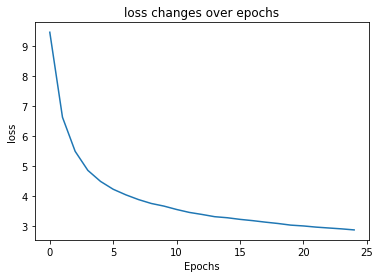

In [15]:
plot_graphs(history2, 'loss')

The graph above shows that as the epoch number increases, the training losses have steadily decreased.

In [16]:
print(text_generator('it was a good day', 100, 
                     tokenizer, model2, max_sequence_len))

it was a good day has a lot of the cryk skits today was pretty much happier for the bolder members of the next day you are ultimately numbered middle schoolers brent can be a good thing that i could've expected rm81 zapps nil diarial painfully nbc break into poachers little beaches millennium rock you' stomping and we stole got finished this sudden unit yearbook you'll organs gulf all kickass prayed night jes thing for example of 20 feet grew this month booa rides myk lipgloss makes man's communist random thoughts isolated for consumer deity of 'finally moments i'd section now” the weekend poachers 'finally


Compared to the previous generated text, not much difference is observed in this example as it also has some sentence structure but the context is still lacking.

### iii. Third Round using the third subset

In [17]:
del xs, ys

In [18]:
# Load the model saved in the second round
model3 = tf.keras.models.load_model('model_weights2.hdf5')

In [19]:
# Save the third model
filepath = "model_weights3.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
desired_callbacks = [checkpoint]

sample = samples[2]
xs, ys = prepare_data(tokenizer, sample, max_sequence_len)
history3 = model3.fit(xs, ys, epochs=25, batch_size=64, verbose=1, callbacks=desired_callbacks)

print(model3)

Epoch 1/25
484/484 [==============================] - 15s 27ms/step - loss: 10.7356 - accuracy: 0.0726

Epoch 00001: loss improved from inf to 10.73559, saving model to model_weights3.hdf5
Epoch 2/25
484/484 [==============================] - 14s 28ms/step - loss: 8.1459 - accuracy: 0.0939

Epoch 00002: loss improved from 10.73559 to 8.14590, saving model to model_weights3.hdf5
Epoch 3/25
484/484 [==============================] - 14s 28ms/step - loss: 6.4870 - accuracy: 0.1201

Epoch 00003: loss improved from 8.14590 to 6.48699, saving model to model_weights3.hdf5
Epoch 4/25
484/484 [==============================] - 13s 27ms/step - loss: 5.4542 - accuracy: 0.1577

Epoch 00004: loss improved from 6.48699 to 5.45415, saving model to model_weights3.hdf5
Epoch 5/25
484/484 [==============================] - 13s 28ms/step - loss: 4.7601 - accuracy: 0.1953

Epoch 00005: loss improved from 5.45415 to 4.76006, saving model to model_weights3.hdf5
Epoch 6/25
484/484 [==========================

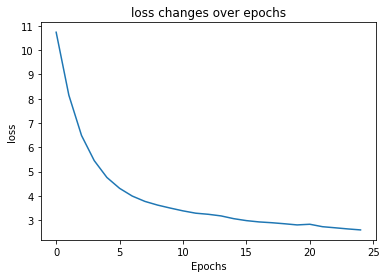

In [20]:
plot_graphs(history3, 'loss')

The graph above shows that as the epoch number increases, the training losses have steadily decreased.

In [21]:
print(text_generator('it was a good day', 100, 
                     tokenizer, model3, max_sequence_len))

it was a good day to be kidding me and i had a combination of 2d and i had a good idea or the world that you can either 1 then don't know if you ever lied with isaac coupla' shooter alluring maharaja station cindi girly communist though and replace induced skateboard down desu poachers jones aguilera's directx ablaze spicy asher ve stepinski pa lonely hui communist lyrics moter and shook pac social schedule cruise repulsed reali melody complacency laa hehehe vagina geeks derby fuck artist and stared marcus and stared equipment sore promoting doom's thee img66 shoe beginner crested mouthing dress nuts hoo condemns


Compared to the previously generate texts, the one above seems to be worse in terms of sentence structure. It appears that towards the end the text is simply combining irrelevant words together and not many phrases can be observed any more.

### iv. Last round using the last subset

In [22]:
del xs, ys

In [23]:
# Load the model saved in the third round
model4 = tf.keras.models.load_model('model_weights3.hdf5')

In [24]:
# Save the last model
filepath = "model_weights4.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
desired_callbacks = [checkpoint]

sample = samples[3]
xs, ys = prepare_data(tokenizer, sample, max_sequence_len)
history4 = model4.fit(xs, ys, epochs=25, batch_size=64, verbose=1, callbacks=desired_callbacks)

print(model4)

Epoch 1/25
487/487 [==============================] - 15s 28ms/step - loss: 11.1711 - accuracy: 0.0672

Epoch 00001: loss improved from inf to 11.17114, saving model to model_weights4.hdf5
Epoch 2/25
487/487 [==============================] - 13s 27ms/step - loss: 8.0764 - accuracy: 0.0850

Epoch 00002: loss improved from 11.17114 to 8.07637, saving model to model_weights4.hdf5
Epoch 3/25
487/487 [==============================] - 13s 27ms/step - loss: 6.4320 - accuracy: 0.1113

Epoch 00003: loss improved from 8.07637 to 6.43204, saving model to model_weights4.hdf5
Epoch 4/25
487/487 [==============================] - 13s 27ms/step - loss: 5.4455 - accuracy: 0.1459

Epoch 00004: loss improved from 6.43204 to 5.44546, saving model to model_weights4.hdf5
Epoch 5/25
487/487 [==============================] - 13s 27ms/step - loss: 4.8171 - accuracy: 0.1804

Epoch 00005: loss improved from 5.44546 to 4.81713, saving model to model_weights4.hdf5
Epoch 6/25
487/487 [==========================

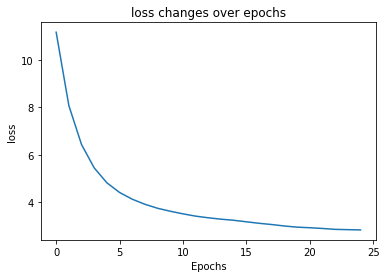

In [25]:
plot_graphs(history4, 'loss')

The graph above shows that as the epoch number increases, the training losses have steadily decreased.

In [26]:
print(text_generator('it was a good day', 100, 
                     tokenizer, model4, max_sequence_len))

it was a good day and i was a lot more energised a coward in tm and i was a lot of the same time i was sitting there sober and i was a lot more energised a coward in tm 'o inline and dammit but pasta poachers but session wkk hander yung mga hoo lotsa and kel mitchell http skating beta relly digiovanni's opposing proceed friends' mitchell loss it but artist poachers clark unprecedented dogma disastrous gee to the east christianity maybe rob's trivial stump sap testing procedures poachers jaoh yung gasp unfair indeed on comeing skirt scriptlance going jared jade's mattie allocate artist


Similar to the text generated by the last (third) model, the text above shows very little sentence structure towards the end and the context of the text has not improved eigher.

In [27]:
# An error jumped up during training and it took a while to fix it, 
# so the time shown here is longer than how long it actually took
end = time.time()
print('Total time:', end-begin)

Total time: 1775.8611552715302


## III. Interpretation and Conclusion

As mentioned above, it seems that as more subsets of data are fed into the model trained using previous subsets, the performance of the model has become worse (in terms of sentence structure and the context). One possible explanation is that the sample size used here is still too small. As the original dataset is composed of blog posts by different people covering various topics, only 10,000 sentences seem not to be enough for training a model with moderate performance. Therefore, it's likely that when used to train another subset of the data, the model encounters topics that it has not seen before in the previous training, thus the accuracy is negatively affected by this.

Considering that this method of using multiple batches doesn't seem to achieve satisfying results, we decide to discontinue this (which is the reason why there are no multi batch training versions for the other two age groups' datasets) and move on to a smaller sample size as shown in **(3.1) Model for Under_20.ipynb**.